# Text Emotion Classification

In [ ]:
# # RUN FOR ONLY Elmo model
# !pip install tensorflow==1.15
# !pip install "tensorflow_hub==0.6.0"
# # !pip3 install tensorflow_text==1.15
# !pip install numpy==1.19.5
# !pip install h5py==2.10.0

In [ ]:
import tensorflow as tf
# import keras
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, GlobalAveragePooling1D
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K


In [ ]:
# tf.enable_eager_execution()
tf.__version__

'2.8.2'

In [ ]:
df_train = pd.read_csv("train.txt",sep=';',names=['text','emotion'])
df_val = pd.read_csv("val.txt",sep=';',names=['text','emotion'])
df_test = pd.read_csv("test.txt",sep=';',names=['text','emotion'])

In [ ]:
df_train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [ ]:
df_train.emotion.value_counts().index

Index(['joy', 'sadness', 'anger', 'fear', 'love', 'surprise'], dtype='object')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train.emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64

Text(0.5, 1.0, 'Distribution Of Sentiments')

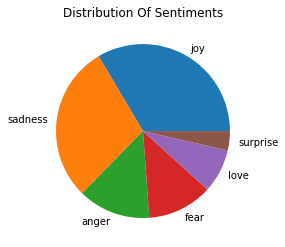

In [ ]:
plt.pie(df_train.emotion.value_counts(), labels=df_train.emotion.value_counts().index)
plt.title('Distribution Of Sentiments')

In [ ]:
data_total = [df_train,df_val,df_test]

In [ ]:
print(f'The total no. of entries in train is', len(data_total[0]) )
print(f'The total no. of entries in validation is', len(data_total[1]) )
print(f'The total no. of entries in test is', len(data_total[2]) )

The total no. of entries in train is 16000
The total no. of entries in validation is 2000
The total no. of entries in test is 2000


In [ ]:
len(data_total[0])

16000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


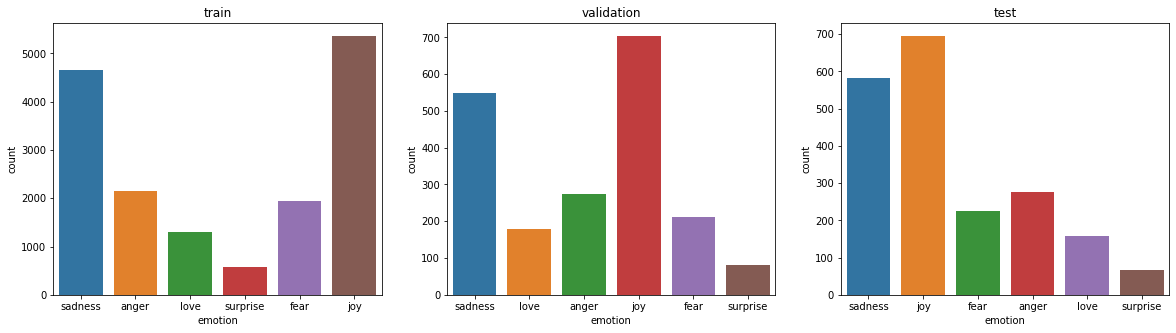

In [ ]:
titles = ['train', 'validation', 'test']
fig,ax = plt.subplots(1,3,figsize=(20,5))
for i,data in enumerate(data_total):
    sns.countplot(data.emotion,ax=ax[i]).set(title=titles[i])


In [ ]:
categories = df_train["emotion"].unique()


In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
).generate(str(data))
    return wordcloud

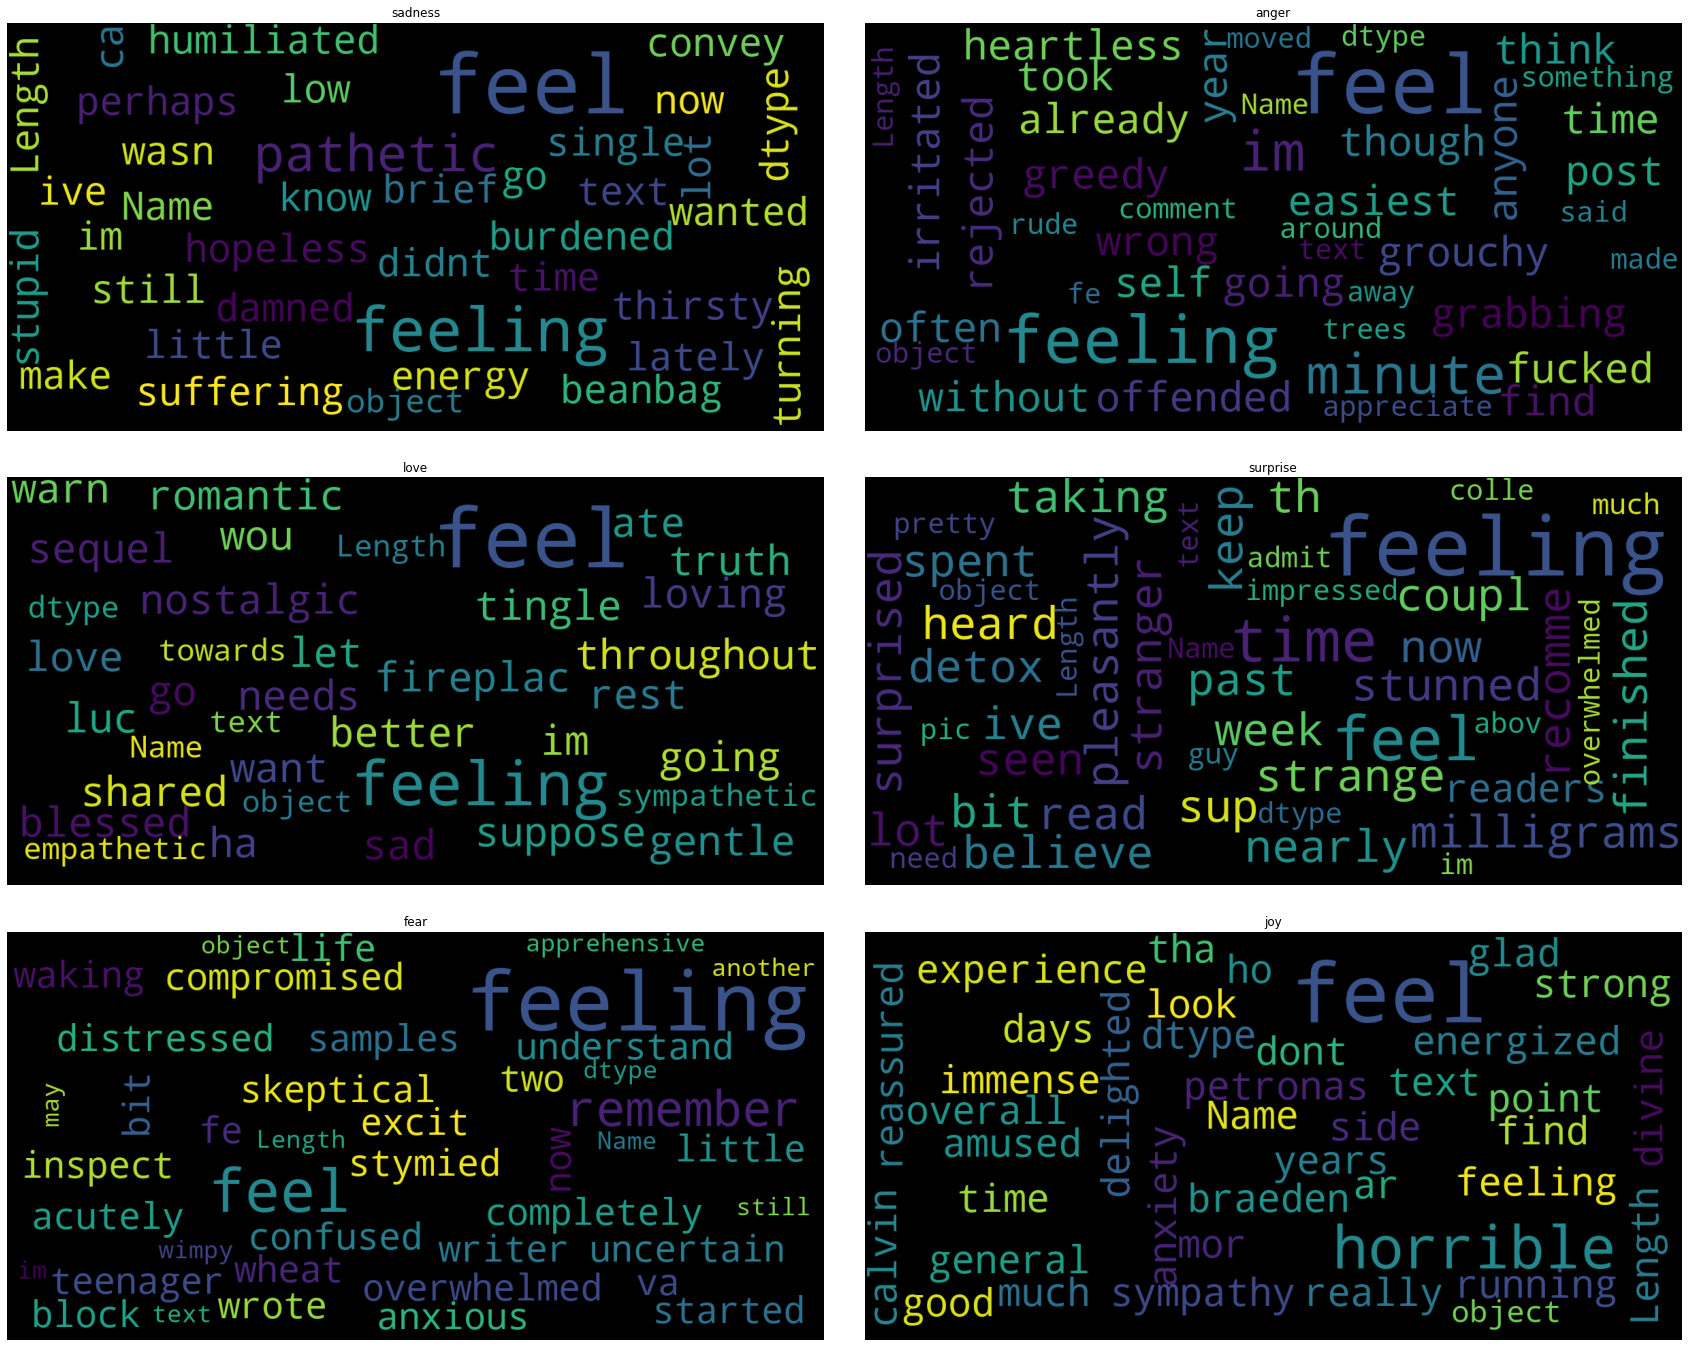

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=3,figsize=(30,25))
plt.axis('off')
for category, ax in zip(categories, axes.flat):
    wordcloud = show_wordcloud(df_train[df_train["emotion"]==category]['text'])
    ax.imshow(wordcloud)
    ax.title.set_text(category)
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)

In [ ]:
vocab_size = 15000

In [ ]:
# Initialize tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                                      lower=False,   # Have kept lower as False, since capitalized words can covey more emotion
                                                      char_level=False,
                                                      oov_token=2,
                                                      filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts('<s> '+df_train.text+' </s>')

In [ ]:
# Initialize one-hot encoder
encoder = OneHotEncoder(sparse=False)
encoder.fit([[i] for i in df_train.emotion])
encoder.categories_

[array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
       dtype=object)]

In [ ]:
encoder.transform([['sadness'],['love']])

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [ ]:
def data_pipeline(dataframe, tokenizer=tokenizer, one_hot_encoder=encoder):
    X = '<s> '+dataframe.text+' </s>'
    y = dataframe.emotion
    X = tf.ragged.constant(tokenizer.texts_to_sequences(X)).to_tensor(default_value=0)
    y = tf.constant(encoder.transform([[j] for j in y]), dtype='int32')
    return X,y

In [ ]:
train_x, train_y = data_pipeline(df_train)
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_data = train_data.shuffle(train_x.shape[0])
train_data = train_data.batch(64)
train_data = train_data.prefetch(AUTOTUNE)

val_x, val_y = data_pipeline(df_val)
val_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_data = val_data.shuffle(val_x.shape[0])
val_data = val_data.batch(64)
val_data = val_data.prefetch(AUTOTUNE)

test_x, test_y = data_pipeline(df_test)
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_data = test_data.shuffle(test_x.shape[0])
test_data = test_data.batch(64)
test_data = test_data.prefetch(AUTOTUNE)

In [ ]:
# View some data from tf dataset
for input, output in train_data.take(1):
  print(input.shape)
  print(input[0])
  print("************************")
  print(output.shape)
  print(output[0])

(64, 68)
tf.Tensor(
[    3     2    87    64    93    64     5    14    13   564    19   346
    12   672     2    90    23    71  5142 12419     4     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(68,), dtype=int32)
************************
(64, 6)
tf.Tensor([0 0 0 0 0 1], shape=(6,), dtype=int32)


## Baseline model - BiLSTM model with randomized word embedding

In [ ]:
X_input = tf.keras.Input(shape = (None,))
X = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=500, mask_zero=True)(X_input)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
outputs = tf.keras.layers.Dense(len(encoder.categories_[0]), activation = 'softmax')(X)
model = tf.keras.Model(inputs = X_input, outputs = outputs)

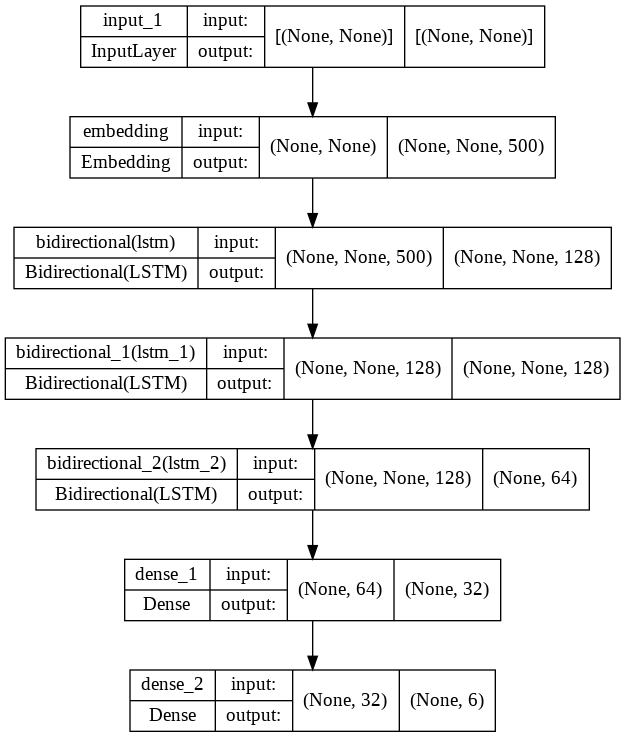

In [ ]:
import keras
keras.utils.vis_utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    restore_best_weights=True,
)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
history = model.fit(train_data, validation_data=val_data, epochs=1000, callbacks=[early])

Train on 250 steps, validate on 32 steps
Epoch 1/1000
250/250 [==============================] - 184s 737ms/step - loss: 0.9852 - acc: 0.6184 - val_loss: 0.4302 - val_acc: 0.8595
Epoch 2/1000
250/250 [==============================] - 198s 791ms/step - loss: 0.2198 - acc: 0.9259 - val_loss: 0.2781 - val_acc: 0.9070
Epoch 3/1000
250/250 [==============================] - 184s 736ms/step - loss: 0.1058 - acc: 0.9613 - val_loss: 0.2704 - val_acc: 0.9150
Epoch 4/1000
250/250 [==============================] - 184s 735ms/step - loss: 0.0746 - acc: 0.9729 - val_loss: 0.2530 - val_acc: 0.9210
Epoch 5/1000
250/250 [==============================] - 176s 705ms/step - loss: 0.0511 - acc: 0.9811 - val_loss: 0.3285 - val_acc: 0.9125
Epoch 6/1000
250/250 [==============================] - 174s 696ms/step - loss: 0.0461 - acc: 0.9833 - val_loss: 0.3036 - val_acc: 0.9165
Epoch 7/1000
250/250 [==============================] - 174s 694ms/step - loss: 0.0428 - acc: 0.9842 - val_loss: 0.3275 - val_acc: 

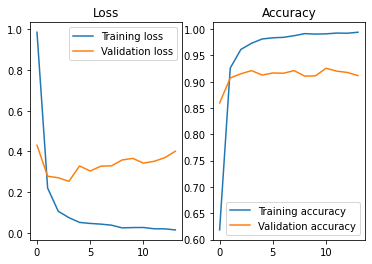

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Loss")
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')
ax[0].legend()
ax[1].set_title("Accuracy")
ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')
ax[1].legend()
plt.show()

In [ ]:
model.evaluate(test_data)

32/32 [==============================] - 6s 189ms/step - loss: 0.2480 - acc: 0.9135


[0.24799308250658214, 0.9135]

In [ ]:
model.save('BiLSTM.h5')

In [ ]:
model = tf.keras.models.load_model('BiLSTM.h5')

def baselinemodel_predictproba(texts):
  texts = ['<s> '+text+' </s>' for text in texts]
  X = tf.ragged.constant(tokenizer.texts_to_sequences(texts)).to_tensor(default_value=0)
  probs = model.predict(X)
  return probs

## BiLSTM model with pretrained Elmo embedding

#### Run first cell ie. install tf==1.5 and its dependents. Required for ELMO embedding
#### Issue - https://github.com/tensorflow/hub/issues/412

In [ ]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

def ELMoEmbedding(input_text):
    return elmo(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

In [ ]:
ELMoEmbedding(["Hi test sentence"])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


<tf.Tensor 'module_apply_default/aggregation/mul_3:0' shape=(1, 3, 1024) dtype=float32>

In [ ]:
def data_pipeline(dataframe):
    X = '<s> '+dataframe.text+' </s>'
    y = dataframe.emotion
#     X = tf.ragged.constant(tokenizer.texts_to_sequences(X)).to_tensor(default_value=0, shape=[None, None])
    y = tf.constant(encoder.transform([[j] for j in y]), dtype='int32')
    return X,y


train_x, train_y = data_pipeline(df_train)
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_data = train_data.shuffle(len(train_x))
train_data = train_data.batch(64)
train_data = train_data.prefetch(AUTOTUNE)

val_x, val_y = data_pipeline(df_val)
val_data = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_data = val_data.shuffle(len(val_x))
val_data = val_data.batch(64)
val_data = val_data.prefetch(AUTOTUNE)

test_x, test_y = data_pipeline(df_test)
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_data = test_data.shuffle(len(test_x))
test_data = test_data.batch(64)
test_data = test_data.prefetch(AUTOTUNE)


In [ ]:
# # View some data from tf dataset
# for input, output in train_data.take(1):
#   print(input.shape)
#   print(input[0])
#   print("************************")
#   print(output.shape)
#   print(output[0])

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM
from tensorflow.keras.models import Model

input_layer = Input(shape=(1,), dtype="string", name="Input_layer")
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences = True))(embedding_layer)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True))(X)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
output_layer = tf.keras.layers.Dense(len(encoder.categories_[0]), activation = 'softmax')(X)

elmo_model = Model(inputs=[input_layer], outputs=output_layer, name="BiLSTM with ELMo Embeddings")
elmo_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "BiLSTM with ELMo Embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 2048)        16785408  
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 128)         1081856   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 6) 

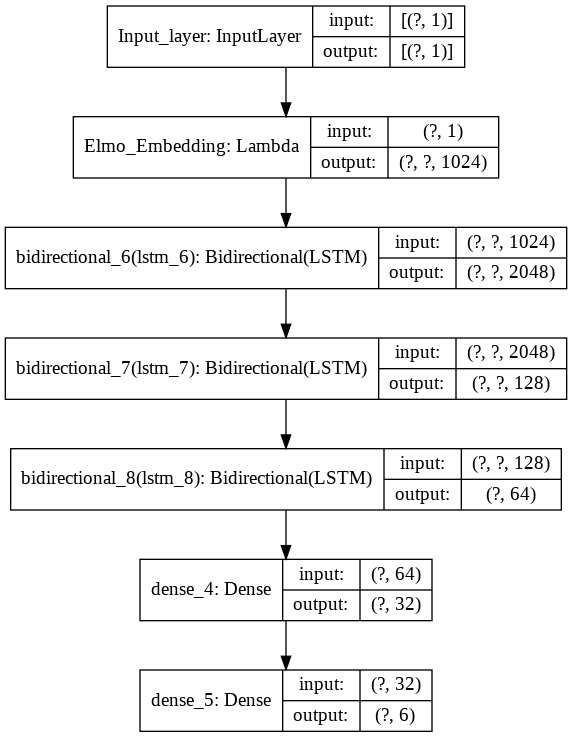

In [ ]:
tf.keras.utils.plot_model(elmo_model, show_shapes=True, show_layer_names=True)

In [ ]:
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    restore_best_weights=True,
)


elmo_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = elmo_model.fit(train_data, validation_data=val_data, epochs=1000, callbacks=[early])
  elmo_model.save('Elmo_BiLSTM.h5')

Train on 250 steps, validate on 32 steps
Epoch 1/1000
250/250 [==============================] - 262s 1s/step - loss: 1.3488 - acc: 0.4719 - val_loss: 1.0481 - val_acc: 0.6000
Epoch 2/1000
250/250 [==============================] - 244s 974ms/step - loss: 0.8737 - acc: 0.6671 - val_loss: 0.6423 - val_acc: 0.7665
Epoch 3/1000
250/250 [==============================] - 243s 974ms/step - loss: 0.4250 - acc: 0.8626 - val_loss: 0.3779 - val_acc: 0.8915
Epoch 4/1000
250/250 [==============================] - 244s 975ms/step - loss: 0.2373 - acc: 0.9215 - val_loss: 0.2551 - val_acc: 0.9175
Epoch 5/1000
250/250 [==============================] - 243s 971ms/step - loss: 0.1522 - acc: 0.9420 - val_loss: 0.2788 - val_acc: 0.9020
Epoch 6/1000
250/250 [==============================] - 243s 972ms/step - loss: 0.1134 - acc: 0.9538 - val_loss: 0.2359 - val_acc: 0.9155
Epoch 7/1000
250/250 [==============================] - 243s 972ms/step - loss: 0.0930 - acc: 0.9609 - val_loss: 0.2301 - val_acc: 0.9

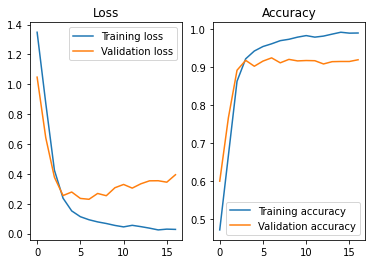

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].set_title("Loss")
ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')
ax[0].legend()
ax[1].set_title("Accuracy")
ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')
ax[1].legend()
plt.show()

In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  elmo_model = tf.keras.models.load_model('Elmo_BiLSTM.h5')
  elmo_model.evaluate(test_data)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


32/32 [==============================] - 627s 20s/step - loss: 0.2422 - acc: 0.9125


In [ ]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  elmo_model = tf.keras.models.load_model('Elmo_BiLSTM.h5')
  probs = elmo_model.predict('<s>' + df_test.text +'</s>')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
predictions = encoder.inverse_transform(pd.get_dummies(np.argmax(probs, axis=1)).values).ravel()
actuals = df_test.emotion

## Classification using BERT

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.4 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 6.6 MB 38.4 MB/s 
     |████████████████████████████████| 596 kB 49.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import  TFDistilBertModel, TFDistilBertForSequenceClassification
from transformers import DistilBertTokenizer
import transformers
from sklearn.model_selection import train_test_split
import re
import sklearn

In [ ]:
# Import the pretrained DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Test sentence to extract the representations
text = ["emotion detection project", "What happened"]

# Extract the encoding of the test sentence from the tokenizer
encoding = tokenizer(text, return_tensors='tf', padding=True)

In [ ]:
# Using tokenizer.batch_decode visualize the representation of the sentences
tokenizer.batch_decode(encoding['input_ids'])

['[CLS] emotion detection project [SEP]', '[CLS] what happened [SEP] [PAD]']

In [ ]:
# Initialize the TFDistilBertModel model with pre-trained weights
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encoder.categories_[0]))


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# View the summary of the model
model.summary()

Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_data = df_train['text']
train_labels = df_train['emotion']

val_data = df_val['text']
val_labels = df_val['emotion']

test_data = df_test['text']
test_labels = df_test['emotion']

In [ ]:
# Tokenize the train data and truncate the sentences with more than 200 tokens
# set padding as true and return_tensors as np
encoded_train_data = tokenizer(train_data.to_list(), padding=True, return_tensors='tf', max_length=200, truncation=True)

In [ ]:
# Tokenize the test data and truncate the sentences with more than 200 tokens
# set padding as true and return_tensors as np
encoded_test_data = tokenizer(test_data.to_list(), padding=True, return_tensors='tf', max_length=200, truncation=True)

In [ ]:
# Tokenize the test data and truncate the sentences with more than 200 tokens
# set padding as true and return_tensors as np
encoded_val_data = tokenizer(val_data.to_list(), padding=True, return_tensors='tf', max_length=200, truncation=True)

In [ ]:
model.trainable = False

In [ ]:
tf.keras.backend.clear_session()

input_ids= tf.keras.layers.Input(shape=[None,], dtype=tf.int32, name='input_ids'),
attention_mask = tf.keras.layers.Input(shape=[None,], dtype=tf.int32, name='attention_mask')

In [ ]:
# Get the sentence embedding of the test sentence by passing the input dictionary
sentence_embedding = model([input_ids, attention_mask])[0]

# Get the embedding of the CLS token of the test sentence
cls_token = sentence_embedding[:, 0, :]

# output = tf.keras.layers.Dense(100, activation='relu')(cls_token)

# Define the output layer of the model with sigmoid activation
# Pass the embedding of the CLS token
output = tf.keras.layers.Dense(len(encoder.categories_[0]), activation='softmax')(cls_token)

# Bring the model together with input as the input dictionary
# output as the output dense layer defiend above
finetuned_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

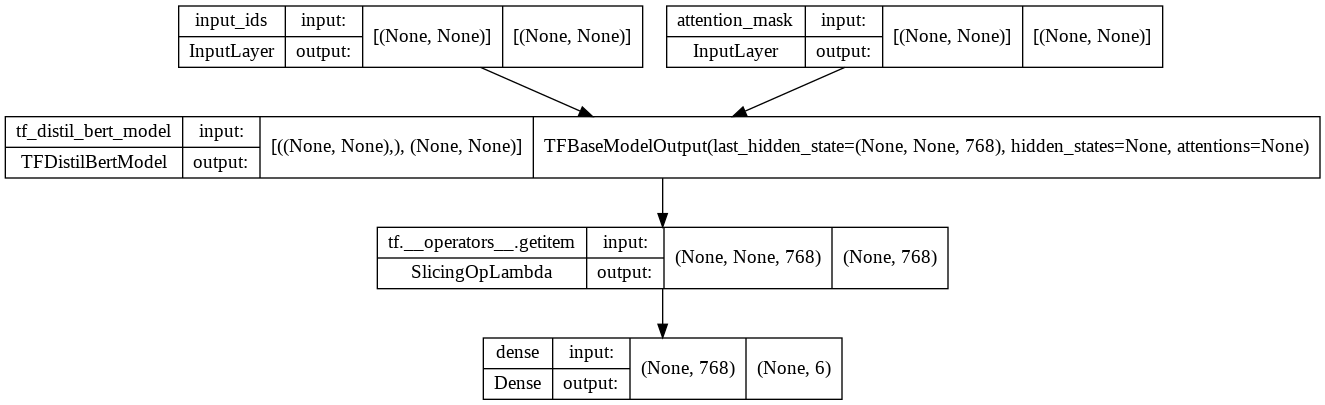

In [ ]:
keras.utils.vis_utils.plot_model(finetuned_model, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the model with loss as binary_crossentropy and adam optimizer

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    restore_best_weights=True,
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=500,
    decay_rate=0.9,
    staircase=True
)

finetuned_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=['accuracy'],
)

In [ ]:
finetuned_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, None, 768),                                                  
                                 hidden_states=None                                           

In [ ]:
encoded_train_labels = encoder.transform([[i] for i in train_labels])
encoded_val_labels = encoder.transform([[i] for i in val_labels])

In [ ]:
# Fit the model on the tokenized train data and use the tokenized
# test data for validation
# Set the number of epochs and batch size

history = finetuned_model.fit(
    [np.array(encoded_train_data.data['input_ids']), np.array(encoded_train_data.data['attention_mask'])],
    encoded_train_labels,
    epochs=1000,
    batch_size=128,
    validation_data=([np.array(encoded_val_data.data['input_ids']), np.array(encoded_val_data.data['attention_mask'])], encoded_val_labels),
    verbose=1,
    callbacks=[early]
)

Epoch 1/1000
125/125 [==============================] - 52s 386ms/step - loss: 1.3328 - accuracy: 0.5023 - val_loss: 1.1808 - val_accuracy: 0.5665
Epoch 2/1000
125/125 [==============================] - 48s 383ms/step - loss: 1.1677 - accuracy: 0.5617 - val_loss: 1.1273 - val_accuracy: 0.5880
Epoch 3/1000
125/125 [==============================] - 48s 386ms/step - loss: 1.1492 - accuracy: 0.5674 - val_loss: 1.0967 - val_accuracy: 0.5880
Epoch 4/1000
125/125 [==============================] - 49s 393ms/step - loss: 1.1406 - accuracy: 0.5754 - val_loss: 1.0968 - val_accuracy: 0.6115
Epoch 5/1000
125/125 [==============================] - 49s 396ms/step - loss: 1.1162 - accuracy: 0.5848 - val_loss: 1.0597 - val_accuracy: 0.6065
Epoch 6/1000
125/125 [==============================] - 50s 398ms/step - loss: 1.1086 - accuracy: 0.5832 - val_loss: 1.0680 - val_accuracy: 0.6055
Epoch 7/1000
125/125 [==============================] - 50s 398ms/step - loss: 1.1067 - accuracy: 0.5909 - val_loss: 1

In [ ]:
finetuned_model.save('distilbert_model_lrschedule_batch128_testaccuracy_0-6155.h5')

In [ ]:
# Your code here
encoded_test_labels = encoder.transform([[i] for i in test_labels])
test_metrics = finetuned_model.evaluate([np.array(encoded_test_data.data['input_ids']), np.array(encoded_test_data.data['attention_mask'])], encoded_test_labels)

63/63 [==============================] - 6s 69ms/step - loss: 1.0349 - accuracy: 0.6065


In [ ]:
model = tf.keras.models.load_model('distilbert_model_lrschedule_batch128_testaccuracy_0-6155.h5')


def bert_predictproba(texts):
  encoded_test_data = tokenizer(texts, padding=True, return_tensors='tf', max_length=200, truncation=True)
  probs = finetuned_model.predict([np.array(encoded_test_data.data['input_ids']), np.array(encoded_test_data.data['attention_mask'])])
  return probs

## Visualization - LIME

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 9.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e91a37b6a8cd1bbbc35af33c5b1149f97eb31b0a09c416e5ed20037a96325d63
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names = encoder.categories_[0])

In [ ]:
#@title Model Explainability { display-mode: "form" }
methods = {"Deep BiLSTM model":baselinemodel_predictproba, "BERT":None}
Model = "Deep BiLSTM model" #@param ["Deep BiLSTM model", "BERT"] {type:"string"}
text = "This is the best test sentence" #@param {type:"string"}
proba_method = methods[Model]
exp = explainer.explain_instance(text, proba_method, top_labels=1, num_samples=1000)
# exp.save_to_file('./explain.html' )
exp.show_in_notebook()